In [1202]:
import datetime
import pandas as pd
from IPython.display import Markdown as md
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import patsy as pt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

#inspiration taken from https://www.kaggle.com/code/rexpertneoh/olist-sales-forecasting#%E2%86%B5-%E2%9C%82-Data-Splitting

#Tableau Public workbook:
# https://public.tableau.com/app/profile/derek.stearns2879/viz/ECON8320/PaymentValueovertime2?publish=yes

pd.set_option('max_columns', None)
pd.set_option('max_colwidth',None)
pd.set_option('max_rows',None)


# Project Summary: Find
- A three-month forecast of future sales (numbers and figures)
- Determine the three best-selling categories, and create a forecast of growth in those categories
- Determine the fastest-growing category, and create a forecast for its growth
- Any other insights that you decide are worth mentioning

# Outline
- Import data
- Select columns
- Join data
- Determine best selling categories
- Determine fastest growing category
- Find other insights
- Apply ADF
- Apply Split/test
- Forecast future sales figures
- Forecast future sales numbers
- Forecast categories


# Import Data

In [1203]:
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')


In [1204]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [1205]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [1206]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [1207]:
payments.count()

order_id                103886
payment_sequential      103886
payment_type            103886
payment_installments    103886
payment_value           103886
dtype: int64

In [1208]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [1209]:
items.count()

order_id               112650
order_item_id          112650
product_id             112650
seller_id              112650
shipping_limit_date    112650
price                  112650
freight_value          112650
dtype: int64

# Select Columns

In [1210]:
o_dat = orders[['order_id','order_status','order_purchase_timestamp','order_approved_at']]
pr_dat = products[['product_id','product_category_name']]
#pa_dat = payments[['order_id','payment_value','payment_installments']]

## let's see the number of records for each order status

In [1211]:
o_dat.groupby(['order_status']).count()

,order_id,order_purchase_timestamp,order_approved_at
order_status,,,
approved,2,2,2
canceled,625,625,484
created,5,5,0
delivered,96478,96478,96464
invoiced,314,314,314
processing,301,301,301
shipped,1107,1107,1107
unavailable,609,609,609


## Let's examine our value counts for the orders table

In [1212]:
o_dat.count()

order_id                    99441
order_status                99441
order_purchase_timestamp    99441
order_approved_at           99281
dtype: int64

# Join Data

In [1213]:
o_datf = o_dat[~o_dat['order_status'].isin(['canceled','unavailable','created'])]
#o_datf = o_dat[o_dat['order_status'] != 'cancelled' & o_dat['order_status']!='unavailable']

oi = pd.merge(o_datf, items, how="left", on=["order_id"])
oip = pd.merge(oi, pr_dat, how="left", on=["product_id"])
#oipp = pd.merge(oip, pa_dat, how="left", on =['order_id'])


In [1214]:
oip.count()

order_id                    112104
order_status                112104
order_purchase_timestamp    112104
order_approved_at           112089
order_item_id               112101
product_id                  112101
seller_id                   112101
shipping_limit_date         112101
price                       112101
freight_value               112101
product_category_name       110512
dtype: int64

In [1215]:
oip.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria


# Determine Top 3 Categories

In [1216]:
#removed payments, may add back in later
oip['total_sales_by_cat'] = oip['price'].groupby(oip['product_category_name']).transform('sum')


In [1217]:
#not needed
f = oip[['product_category_name','total_sales_by_cat']]

f = f.drop_duplicates()
f = f.sort_values(by=['total_sales_by_cat'], ascending=False)
t3cats = f['product_category_name'].head(3).to_list()
t3cats

['beleza_saude', 'relogios_presentes', 'cama_mesa_banho']

In [1218]:
f.head(3).to_clipboard()

In [1219]:
md("# The Top three categories are: {}".format(t3cats))


# The Top three categories are: ['beleza_saude', 'relogios_presentes', 'cama_mesa_banho']

# Determine fastest growing category

In [1220]:
oip['numprod'] = oip.groupby(['product_category_name']).size()
oip.head()


,order_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,total_sales_by_cat,numprod
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,626825.80,NaN
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,396599.31,NaN
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,586585.73,NaN
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,213766.63,NaN
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,229593.84,NaN


## The cell below initially was using sales price to measure fastest growing, however upon reflection, quantity might be more suitable (as opposed to price) to measure the fastest growing.

In [1221]:
# fa = oip[['product_category_name','price','order_purchase_timestamp']]
# fa['order_dte'] = pd.to_datetime(oip['order_purchase_timestamp']).dt.strftime('%Y.%m')
# #fa.head()
# #fa['cat_sales'] = fa.groupby(['product_category_name','order_dte'])['price'].transform('sum')
# fa['cat_sales'] = fa.groupby(['product_category_name','order_dte'])['price'].transform('sum')
# fa.head()
# fa_f = fa[['cat_sales','product_category_name','order_dte']]
# fa_f.head()
# fa_f = fa_f.sort_values(by=['product_category_name','order_dte'], ascending=False)
# fa_f = fa_f.drop_duplicates()

# fa_f.head(20)

## Change data to get sales quantities by YYYY.MM

In [1222]:
#get columns
fa = oip[['product_category_name','order_purchase_timestamp']]
#format order date to YYYY.MM
fa['order_dte'] = pd.to_datetime(oip['order_purchase_timestamp']).dt.strftime('%Y.%m')

#get total sales by category and YYYY.MM
cat_sales = fa.groupby(['product_category_name','order_dte']).size().reset_index(name='cat_sales')

#sort valus for running pct_change for MOM value
fa_f = cat_sales.sort_values(by=['product_category_name','order_dte'], ascending=False)


<ipython-input-1222-37c3a221591f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Use pct_change to get Month over Month change

In [1223]:
pivot = pd.pivot_table(fa_f, values='cat_sales', index=['order_dte'], columns=['product_category_name'])
#pivot = pivot.fillna(value=0)
pivot.head(20)
mom = pivot.pct_change(fill_method='ffill')
pivot.head()

#deprecated code fo find max minus min
# maxdf = pivot.idxmax().to_frame('maxx').assign(valmax=lambda d: pivot.lookup(d.maxx, d.index))
# maxdf = maxdf.sort_values(by=['product_category_name'])
# mindf = pivot.ne(0).idxmax().to_frame('minn').assign(valmin=lambda d: pivot.lookup(d.minn, d.index))
# mindf = mindf.sort_values(by=['product_category_name'])
#mindf.head()
# result = pd.concat([maxdf, mindf], axis=1, sort=False)
# result['valdif'] = result['valmax'] - result['valmin']
# result['datdif'] = (pd.to_datetime(result['maxx']) - pd.to_datetime(result['minn'])).dt.days
# result['slope'] = result['valdif']/result['datdif']
# result = result.sort_values(by='slope', ascending = False)
# result.head(20)
#output = pivot.pct_change()
#output.head(50)

product_category_name,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,bebes,bebidas,beleza_saude,brinquedos,cama_mesa_banho,casa_conforto,casa_conforto_2,casa_construcao,cds_dvds_musicais,cine_foto,climatizacao,consoles_games,construcao_ferramentas_construcao,construcao_ferramentas_ferramentas,construcao_ferramentas_iluminacao,construcao_ferramentas_jardim,construcao_ferramentas_seguranca,cool_stuff,dvds_blu_ray,eletrodomesticos,eletrodomesticos_2,eletronicos,eletroportateis,esporte_lazer,fashion_bolsas_e_acessorios,fashion_calcados,fashion_esporte,fashion_roupa_feminina,fashion_roupa_infanto_juvenil,fashion_roupa_masculina,fashion_underwear_e_moda_praia,ferramentas_jardim,flores,fraldas_higiene,industria_comercio_e_negocios,informatica_acessorios,instrumentos_musicais,la_cuisine,livros_importados,livros_interesse_geral,livros_tecnicos,malas_acessorios,market_place,moveis_colchao_e_estofado,moveis_cozinha_area_de_servico_jantar_e_jardim,moveis_decoracao,moveis_escritorio,moveis_quarto,moveis_sala,musica,papelaria,pc_gamer,pcs,perfumaria,pet_shop,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas
order_dte,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016.10,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,9.0,11.0,NaN,46.0,24.0,8.0,NaN,NaN,NaN,NaN,NaN,10.0,10.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,1.0,NaN,17.0,8.0,1.0,NaN,1.0,NaN,1.0,NaN,5.0,NaN,1.0,4.0,21.0,NaN,NaN,NaN,1.0,1.0,NaN,13.0,NaN,NaN,67.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,29.0,4.0,NaN,NaN,5.0,NaN,NaN,NaN,9.0,5.0,12.0
2016.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017.01,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,33.0,41.0,NaN,85.0,42.0,48.0,NaN,2.0,NaN,NaN,NaN,4.0,23.0,1.0,NaN,NaN,NaN,NaN,40.0,2.0,NaN,8.0,11.0,6.0,80.0,35.0,1.0,NaN,2.0,NaN,1.0,2.0,58.0,NaN,NaN,NaN,31.0,1.0,NaN,NaN,2.0,NaN,5.0,6.0,NaN,1.0,182.0,10.0,8.0,10.0,2.0,14.0,NaN,1.0,34.0,15.0,NaN,NaN,11.0,1.0,NaN,NaN,26.0,22.0,28.0
2017.02,7.0,9.0,NaN,NaN,NaN,NaN,NaN,5.0,85.0,34.0,NaN,166.0,66.0,163.0,3.0,NaN,4.0,NaN,1.0,12.0,18.0,3.0,NaN,NaN,2.0,1.0,70.0,1.0,7.0,1.0,19.0,28.0,155.0,39.0,3.0,NaN,4.0,NaN,7.0,8.0,71.0,NaN,NaN,1.0,106.0,9.0,NaN,1.0,8.0,1.0,21.0,21.0,NaN,2.0,265.0,63.0,1.0,22.0,NaN,19.0,NaN,1.0,50.0,40.0,NaN,NaN,37.0,NaN,NaN,8.0,109.0,22.0,79.0


## pivot the dataframe

In [1224]:
mom = mom.fillna(value=0)
ff = mom.T.reset_index()
ff.head()

#ff.to_csv('../month_over_month.csv')

order_dte,product_category_name,2016.09,2016.10,2016.12,2017.01,2017.02,2017.03,2017.04,2017.05,2017.06,2017.07,2017.08,2017.09,2017.10,2017.11,2017.12,2018.01,2018.02,2018.03,2018.04,2018.05,2018.06,2018.07,2018.08,2018.09
0,agro_industria_e_comercio,0.0,0.0,0.0,0.0,1.333333,-0.714286,0.000000,1.000000,-0.750000,0.0,3.000000,0.000,0.250000,2.800000,-0.421053,0.636364,0.500000,0.037037,-0.571429,-0.333333,0.250000,2.000000,-0.400000,0.0
1,alimentos,0.0,0.0,0.0,1.0,3.500000,1.666667,-0.666667,-0.625000,-0.666667,6.0,0.142857,1.125,0.000000,0.000000,-0.176471,0.428571,0.900000,-0.078947,0.142857,0.100000,-0.454545,1.666667,0.812500,0.0
2,alimentos_bebidas,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.250000,4.666667,-0.882353,3.0,0.875000,-0.400,0.888889,0.941176,-0.333333,-0.500000,1.181818,-0.208333,-0.052632,0.388889,-0.560000,0.545455,0.235294,0.0
3,artes,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.800000,7.000000,0.250000,-0.7,0.333333,-0.250,0.000000,-0.666667,2.000000,5.333333,-0.368421,-0.416667,2.714286,0.384615,-0.222222,-0.250000,-0.142857,0.0
4,artes_e_artesanato,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-0.181818,0.0


## Sum the dataframe to get the largest Month over month value in 2018

In [1225]:
collist = ['2018.01','2018.02','2018.03','2018.04','2018.05','2018.06','2018.07','2018.08','2018.09']
ff['summ']= ff[collist].sum(axis=1)
ff = ff.sort_values(by=['summ'], ascending = False)
ff.head()

order_dte,product_category_name,2016.09,2016.10,2016.12,2017.01,2017.02,2017.03,2017.04,2017.05,2017.06,2017.07,2017.08,2017.09,2017.10,2017.11,2017.12,2018.01,2018.02,2018.03,2018.04,2018.05,2018.06,2018.07,2018.08,2018.09,summ
4,artes_e_artesanato,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,-0.181818,0.0,9.818182
19,climatizacao,0.0,0.0,0.0,-0.6,2.0,0.416667,-0.058824,-0.500000,0.375,-0.545455,2.000000,-0.533333,0.714286,0.583333,-0.842105,8.666667,-0.586207,1.083333,-0.080000,-0.391304,0.071429,0.133333,0.235294,0.0,9.132545
64,portateis_casa_forno_e_cafe,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000,1.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,4.000000,0.400000,1.142857,-0.400000,-0.666667,4.000000,0.133333,0.0,8.609524
68,sinalizacao_e_seguranca,0.0,0.0,0.0,0.0,0.0,0.000000,2.000000,0.333333,-0.500,2.000000,-0.333333,1.250000,0.111111,-0.500000,-0.600000,3.000000,0.875000,-0.400000,3.000000,-0.805556,2.857143,0.074074,-0.241379,0.0,8.359282
5,artigos_de_festas,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,1.000000,0.000000,1.000000,-0.500000,0.000000,0.000000,2.000000,-0.666667,1.000000,-0.500000,0.000000,6.000000,0.0,7.833333


# Artes_e_artesanato is the fastest growing category

In [1226]:
#deprecated code for outputing to csv for using with Tableau

# fff = pd.melt(ff, id_vars=['product_category_name'], value_vars=ff.columns.difference(['product_category_name']))
# fff['dt'] = pd.to_datetime(fff.order_dte)
# fff.head()
# fff.to_csv('month_over_month.csv')

# Forecast 3 Months of Sales

## which date should be used for time series?
- A three-month forecast of future sales (numbers and figures) (Let's use Order_Purchase_T? There are about 240 orders that appear to not be approved)
 - figures = sales of categories overall, numbers = total product? 
- Determine the three best-selling categories, and create a forecast of growth in those categories
- Determine the fastest-growing category, and create a forecast for its growth
- Any other insights that you decide are worth mentioning

### 1: 3 Month forecast of future sales

In [1227]:
#get sales
oip.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,total_sales_by_cat,numprod
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,626825.80,NaN
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,396599.31,NaN
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,586585.73,NaN
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,213766.63,NaN
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,229593.84,NaN


In [1228]:
df_sales = oip[['order_purchase_timestamp','price']]

In [1229]:
df_sales['sales_dt'] = pd.to_datetime(df_sales.order_purchase_timestamp, infer_datetime_format=True)

<ipython-input-1229-2eb4b9f94261>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1230]:
df_sales.head()

,order_purchase_timestamp,price,sales_dt
0,2017-10-02 10:56:33,29.99,2017-10-02 10:56:33
1,2018-07-24 20:41:37,118.70,2018-07-24 20:41:37
2,2018-08-08 08:38:49,159.90,2018-08-08 08:38:49
3,2017-11-18 19:28:06,45.00,2017-11-18 19:28:06
4,2018-02-13 21:18:39,19.90,2018-02-13 21:18:39


In [1231]:

df_sales['new_dt'] = df_sales['sales_dt'].dt.round("D")
df_sales.head()
df_sales = df_sales.groupby(['new_dt'])['price'].sum().reset_index(['new_dt'])
df_sales = df_sales.set_index(['new_dt'])


<ipython-input-1231-de234f15fcab>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1232]:
df_sales.sort_values('new_dt',ascending = True).head()


,price
new_dt,
2016-09-05,72.89
2016-09-16,134.97
2016-10-03,29.90
2016-10-04,1120.46
2016-10-05,10714.10


In [1233]:
df_sales[df_sales['price']<0].count()

price    0
dtype: int64

In [1234]:
df_sales.count()

price    616
dtype: int64

In [1235]:
## check for duplicates
pd.concat(g for _, g in df_sales.groupby("new_dt") if len(g) > 1)

ValueError: No objects to concatenate

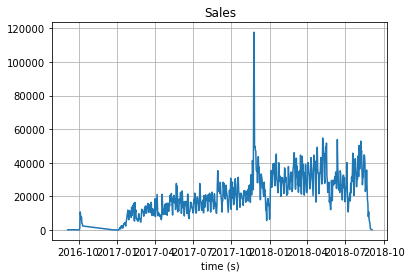

In [1236]:
fig, ax = plt.subplots()
ax.plot(df_sales)

ax.set(xlabel='time (s)', ylabel='',
       title='Sales')
ax.grid()

fig.savefig("test.png")
plt.show()

In [1237]:
#remove some extraneous dates

df_sales = df_sales.reset_index()
df_sales = df_sales[df_sales['new_dt'] > pd.to_datetime('2017-01-07')]
df_sales = df_sales[df_sales['new_dt']< pd.to_datetime('2018-08-17')] ##seems most accurate regarding annomaly
#df_sales = df_sales[df_sales['new_dt']< pd.to_datetime('2018-08-31')] ##

df_sales.head()

,new_dt,price
15,2017-01-08,1396.89
16,2017-01-09,706.69
17,2017-01-10,596.79
18,2017-01-11,2310.36
19,2017-01-12,1795.57


In [1238]:
sales = df_sales['price']
sales.index = pd.to_datetime(df_sales['new_dt'])
sales.index.freq = sales.index.inferred_freq

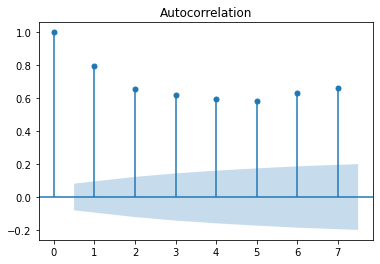

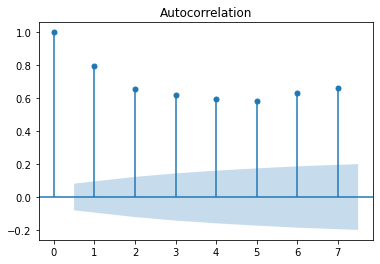

In [1239]:
plot_acf(sales, lags = 7)

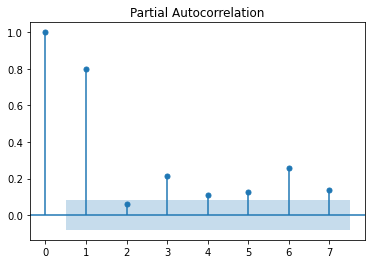

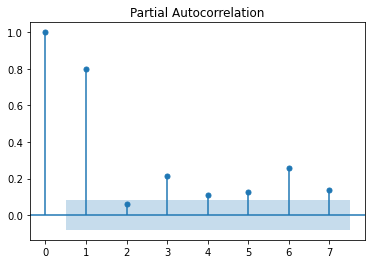

In [1240]:
plot_pacf(sales, lags = 7)

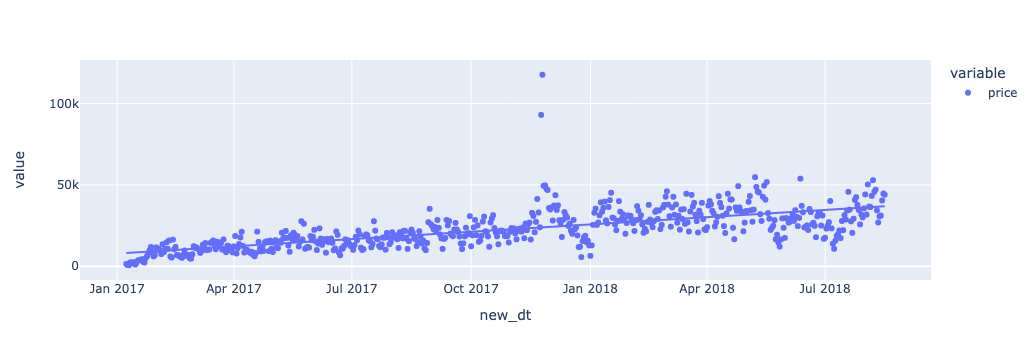

In [1241]:
fig = px.scatter(sales, trendline='ols')
fig.show()

In [1242]:
adfuller(sales, maxlag=7 )

(-2.9940008240671245,
 0.0354584586731736,
 7,
 578,
 {'1%': -3.441714324024304,
  '5%': -2.8665533998436215,
  '10%': -2.5694399997605393},
 11821.468192214807)

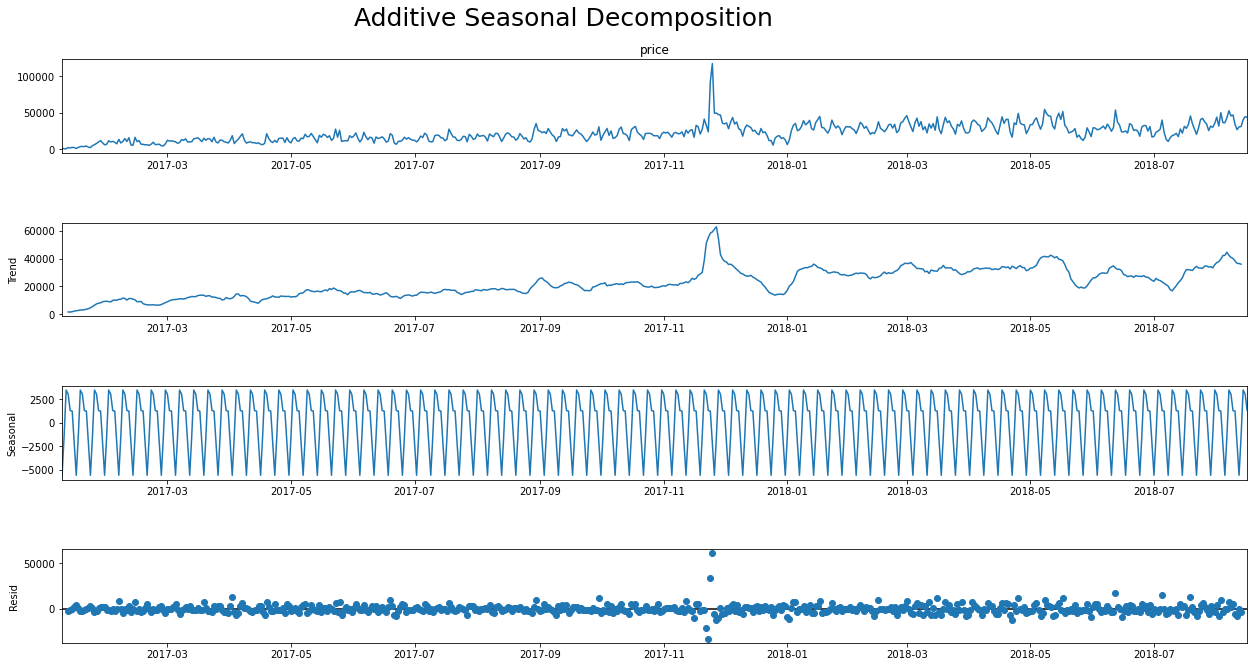

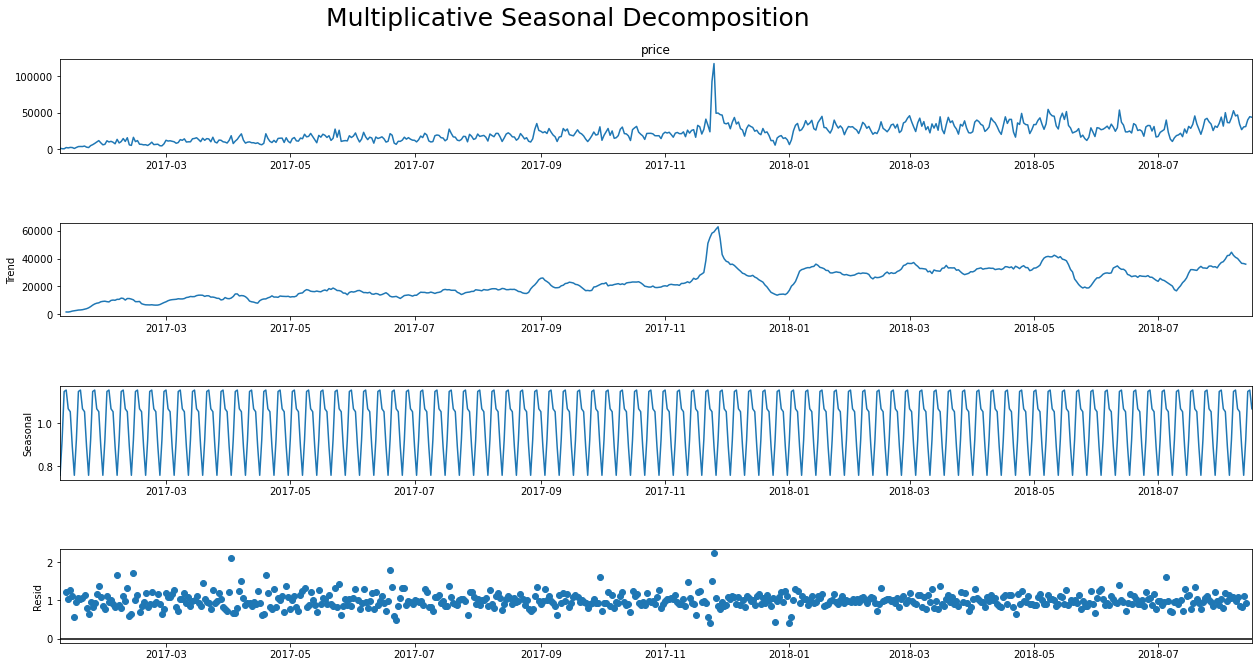

In [1243]:

seasonal_a = seasonal_decompose(sales, model='additive')
seasonal_m = seasonal_decompose(sales, model='multiplicative')
fig_1 = seasonal_a.plot()
fig_2 = seasonal_m.plot()
fig_1.suptitle('Additive Seasonal Decomposition', fontsize=25)
fig_1.set_figheight(10)
fig_1.set_figwidth(20)
fig_2.suptitle('Multiplicative Seasonal Decomposition', fontsize=25)
fig_2.set_figheight(10)
fig_2.set_figwidth(20)
plt.show()

In [1244]:
pred_time = pd.date_range(datetime.date(2018, 5, 17), datetime.date(2018, 8, 16))
su_pred_time =  pd.date_range(datetime.date(2018, 5, 17), datetime.date(2018, 11, 16))
test_time = pd.date_range(datetime.date(2018, 5, 17), datetime.date(2018, 8, 16))
test_vals = sales[sales.index > datetime.datetime(2018, 5, 16)]

# Make forecast

In [1245]:
# Linear trend with damping
#dampedTrend = ExponentialSmoothing(sales, trend='add', seasonal_periods = 7 , seasonal='add').fit(damping_trend=0.70)
dampedTrend = ExponentialSmoothing(sales
                                   , trend='add'
                                   , seasonal_periods = 7
                                   , seasonal='add').fit(damping_trend=0.70
                                                         ,smoothing_level=0.2
                                                         , smoothing_trend=0
                                                         , smoothing_seasonal=0.8, method='ls')



forecast_dt = dampedTrend.forecast(90)

pred = dampedTrend.forecast(pred_time.shape[0])

su_pred = dampedTrend.forecast(su_pred_time.shape[0])

/Users/derek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



In [1246]:
forecast_dt.sum()

3462330.383635856

In [1247]:
print(sales.index.inferred_freq)

D


## Prep data for graph

In [1248]:
smoothData = pd.DataFrame([sales.values, dampedTrend.fittedvalues]).T
smoothData.columns = ['Truth',  'Damped Trend']
smoothData.index = sales.index

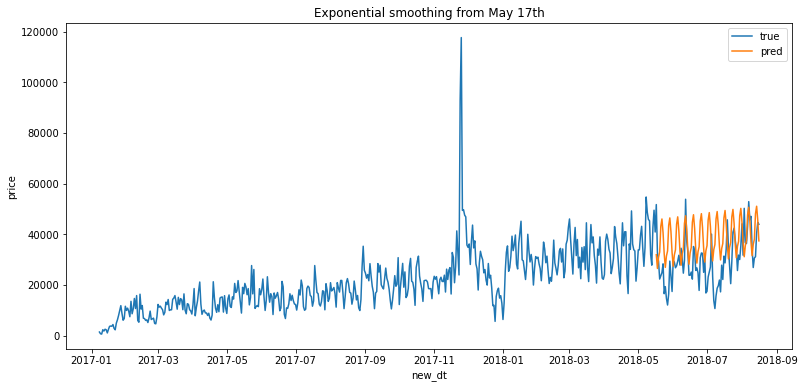

In [1249]:
fig, ax = plt.subplots(figsize=(13,6))

sns.lineplot(x=smoothData.index, y=sales, label='true')
sns.lineplot(x=pred_time, y=pred, label='pred')
#sns.lineplot(x = smoothData.index, y= dampedTrend.fittedvalues, label="damped")
#ax.axvline(x=pred_time[0], color='green')

ax.set_title('Exponential smoothing from May 17th')
plt.show()

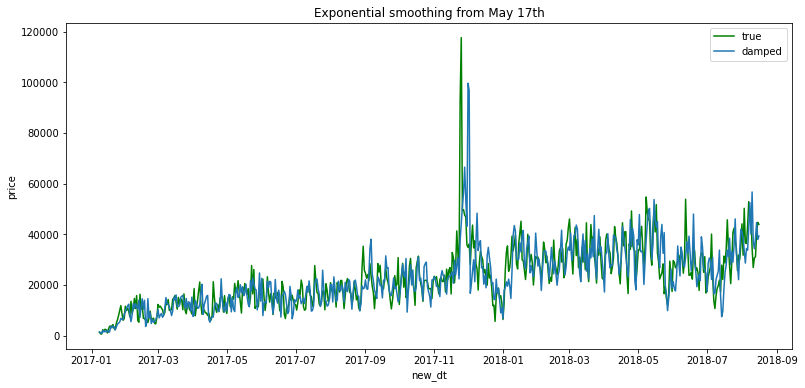

In [1250]:
fig, ax = plt.subplots(figsize=(13,6))

sns.lineplot(x=smoothData.index, y=sales, label='true', color="green")
#sns.lineplot(x=pred_time, y=pred, label='pred')
sns.lineplot(x = smoothData.index, y= dampedTrend.fittedvalues, label="damped")
#ax.axvline(x=pred_time[0], color='green')

ax.set_title('Exponential smoothing from May 17th')
plt.show()

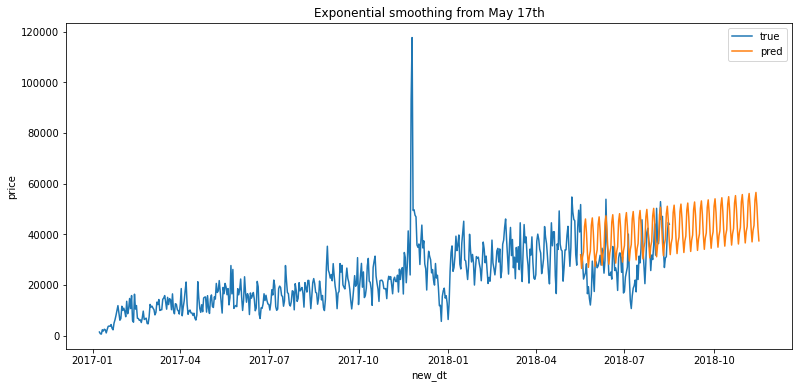

In [1251]:
fig, ax = plt.subplots(figsize=(13,6))

sns.lineplot(x=smoothData.index, y=sales, label='true')
sns.lineplot(x=su_pred_time, y=su_pred, label='pred')
#ax.axvline(x=pred_time[0], color='green')

ax.set_title('Exponential smoothing from May 17th')
plt.show()

In [1252]:
#get rmse
rmse = sum([(np.squeeze(pred)[i]-test_vals[i])**2 for i in range(len(np.squeeze(pred)))])
rmse = np.sqrt(rmse)*1/90
rmse

1436.7287107082832

In [1253]:
test_vals.sum()

2728938.6000000043

In [1254]:
pred.sum()

3545374.4721313273

In [1255]:
su_pred.sum()

7592242.633977526

In [1256]:
#final prediction
(su_pred.sum()) - (pred.sum())

4046868.1618461986

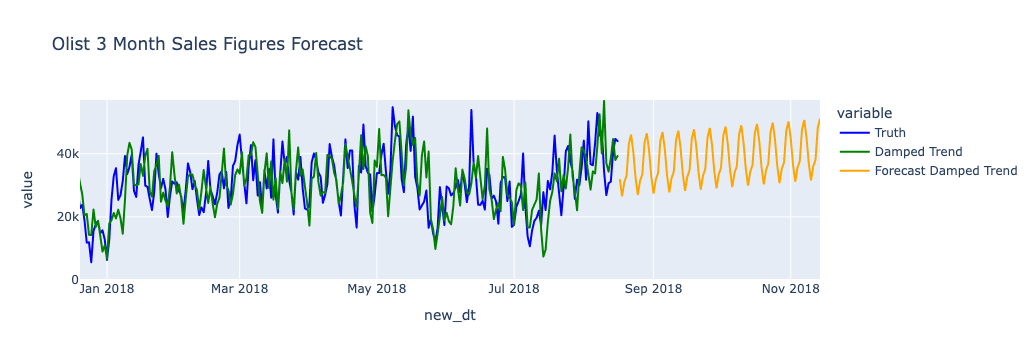

In [1257]:
import plotly.graph_objects as go


fig = px.line(smoothData, y = ['Truth',  'Damped Trend'], 
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                            'Damped Trend': 'green'
                           },
              title='Olist 3 Month Sales Figures Forecast'
       )

fig.update_xaxes(range=[smoothData.index[-240], forecast_dt.index[-1]])
fig.update_yaxes(range=[0, 57000])


# Incorporating the Forecasts

fig.add_trace(go.Scatter(x=forecast_dt.index, y = forecast_dt, name='Forecast Damped Trend', line={'color':'orange'}))

fig.show()

## Sales numbers

In [1258]:
df_sales = oip[['order_purchase_timestamp','price']]

In [1259]:
oip['total_items_in_order'] = oip.groupby(["order_id"])["order_item_id"].transform("count")

In [1260]:
check = oip[oip['total_items_in_order']!=1]
check.count()


order_id                    23666
order_status                23666
order_purchase_timestamp    23666
order_approved_at           23664
order_item_id               23663
product_id                  23663
seller_id                   23663
shipping_limit_date         23663
price                       23663
freight_value               23663
product_category_name       23347
total_sales_by_cat          23347
numprod                         0
total_items_in_order        23666
dtype: int64

In [1261]:
#total sales figure
oip['total_product_charge'] = oip.groupby(['order_id','product_id','order_item_id'])['price'].transform('sum')
price_pmt = oip[['product_id','order_id','order_item_id','product_category_name','price','total_items_in_order','order_purchase_timestamp']]

price_pmt_f = price_pmt.drop_duplicates()

In [1262]:
sales_fig = price_pmt_f.groupby(['product_category_name'])['price'].sum().reset_index()
sales_fig.sort_values('price',ascending=False).head()

,product_category_name,price
11,beleza_saude,1255695.13
66,relogios_presentes,1198185.21
13,cama_mesa_banho,1035964.06
32,esporte_lazer,979740.92
44,informatica_acessorios,904322.02


In [1263]:
price_pmt.head()

,product_id,order_id,order_item_id,product_category_name,price,total_items_in_order,order_purchase_timestamp
0,87285b34884572647811a353c7ac498a,e481f51cbdc54678b7cc49136f2d6af7,1.0,utilidades_domesticas,29.99,1,2017-10-02 10:56:33
1,595fac2a385ac33a80bd5114aec74eb8,53cdb2fc8bc7dce0b6741e2150273451,1.0,perfumaria,118.70,1,2018-07-24 20:41:37
2,aa4383b373c6aca5d8797843e5594415,47770eb9100c2d0c44946d9cf07ec65d,1.0,automotivo,159.90,1,2018-08-08 08:38:49
3,d0b61bfb1de832b15ba9d266ca96e5b0,949d5b44dbf5de918fe9c16f97b45f8a,1.0,pet_shop,45.00,1,2017-11-18 19:28:06
4,65266b2da20d04dbe00c5c2d3bb7859e,ad21c59c0840e6cb83a9ceb5573f8159,1.0,papelaria,19.90,1,2018-02-13 21:18:39


In [1264]:
price_pmt.drop(columns=['order_id','product_id','order_item_id','price'], inplace=True)
price_pmt['new_dt'] = pd.to_datetime(price_pmt['order_purchase_timestamp']).dt.round("D")
price_pmt.drop(columns=['order_purchase_timestamp','product_category_name'], inplace=True)
price_pmt['volume_sales'] = price_pmt.groupby(['new_dt'])['total_items_in_order'].transform('sum')
price_pmt.drop(columns=['total_items_in_order'],inplace=True)
price_pmt.head()

/Users/derek/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1264-263303aa24db>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-1264-263303aa24db>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,new_dt,volume_sales
0,2017-10-02,184
1,2018-07-25,442
2,2018-08-08,519
3,2017-11-19,246
4,2018-02-14,446


In [1265]:
price_pmt=price_pmt.drop_duplicates()

In [1266]:
price_pmt.dtypes

new_dt          datetime64[ns]
volume_sales             int64
dtype: object

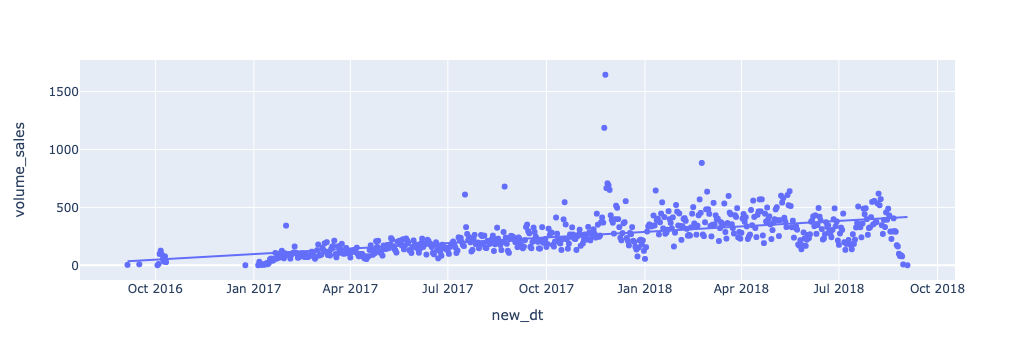

In [1267]:
fig = px.scatter(price_pmt, trendline='ols', x='new_dt',y='volume_sales')
fig.show()

In [1268]:
# for i in price_pmt['product_category_name'].unique():
#     d = price_pmt[price_pmt['product_category_name']==i].copy()
 
#     d.drop(columns=['product_category_name'], inplace=True)
#     print(i)
#     #print(d.head())
#     fig = px.scatter(d, trendline='ols', x='new_dt',y='volume_sales')
#     fig.show()

In [1269]:
price_pmt.head()

,new_dt,volume_sales
0,2017-10-02,184
1,2018-07-25,442
2,2018-08-08,519
3,2017-11-19,246
4,2018-02-14,446


In [1270]:
#remove some extraneous dates
train_time = pd.date_range(datetime.date(2017, 12, 31), datetime.date(2018, 5, 17))
sales = price_pmt['volume_sales']
price_pmt = price_pmt[price_pmt['new_dt'] > pd.to_datetime('2017-01-07')]
price_pmt = price_pmt[price_pmt['new_dt']< pd.to_datetime('2018-08-17')] ##seems most accurate regarding annomaly
#df_sales = df_sales[df_sales['new_dt']< pd.to_datetime('2018-08-31')] ##

train_sales = price_pmt['volume_sales']
train_sales.index = pd.to_datetime(price_pmt['new_dt'])

idx = train_time
s = train_sales
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(idx, fill_value=0)

# Linear trend with damping
#dampedTrend = ExponentialSmoothing(sales, trend='add', seasonal_periods = 7 , seasonal='add').fit(damping_trend=0.70)
dampedTrend = ExponentialSmoothing(s
                                   , trend='mul'
                                   , seasonal_periods = 7
                                   , seasonal='add').fit(damping_trend=0.9
                                                         ,smoothing_level=0.6
                                                         , smoothing_trend=0
                                                         , smoothing_seasonal=0.8, method='ls')



forecast_dt = dampedTrend.forecast(90)

pred = dampedTrend.forecast(pred_time.shape[0])

su_pred = dampedTrend.forecast(su_pred_time.shape[0])
#s.index.freq = sales.index.inferred_freq

/Users/derek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



In [1271]:
#get rmse
test_vals = price_pmt[price_pmt.new_dt > datetime.datetime(2018, 5, 17)]

idx = test_time
s1 = test_vals['volume_sales']
s1.index = pd.DatetimeIndex(test_vals.new_dt)
s1 = s1.reindex(idx, fill_value=0)

rmse = sum([(np.squeeze(pred)[i]-s1[i])**2 for i in range(len(np.squeeze(pred)))])
rmse = np.sqrt(rmse)*1/90
rmse

22.591021856349077

In [1272]:
pred.sum()

44337.258490405

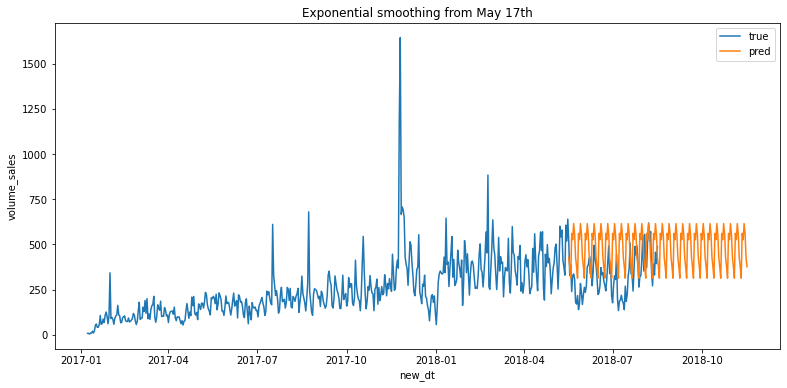

In [1273]:
fig, ax = plt.subplots(figsize=(13,6))
sales = price_pmt['volume_sales']
sns.lineplot(x=sales.index, y=sales, label='true')
sns.lineplot(x=su_pred_time, y=su_pred, label='pred')
#ax.axvline(x=pred_time[0], color='green')

ax.set_title('Exponential smoothing from May 17th')
plt.show()

/Users/derek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



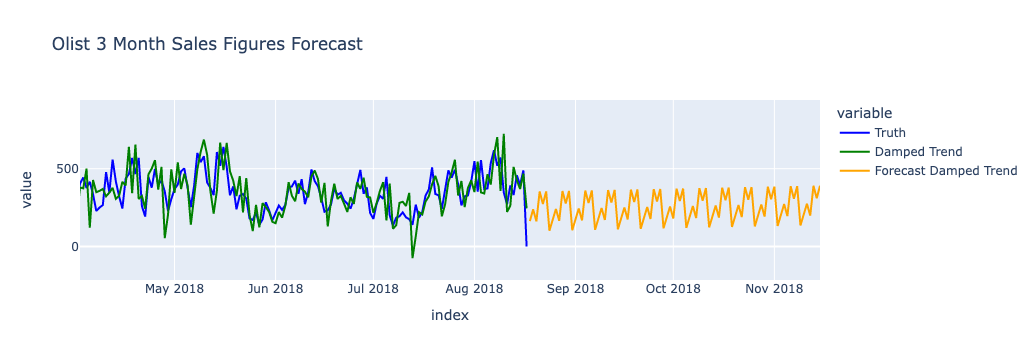

In [1274]:
#remove some extraneous dates
train_time = pd.date_range(datetime.date(2017, 12, 31), datetime.date(2018, 8, 17))
sales = price_pmt['volume_sales']
price_pmt = price_pmt[price_pmt['new_dt'] > pd.to_datetime('2017-01-07')]
price_pmt = price_pmt[price_pmt['new_dt']< pd.to_datetime('2018-08-17')] ##seems most accurate regarding annomaly
#df_sales = df_sales[df_sales['new_dt']< pd.to_datetime('2018-08-31')] ##

train_sales = price_pmt['volume_sales']
train_sales.index = pd.to_datetime(price_pmt['new_dt'])

idx = train_time
s = train_sales
s.index = pd.DatetimeIndex(s.index)
s = s.reindex(idx, fill_value=0)

# Linear trend with damping
#dampedTrend = ExponentialSmoothing(sales, trend='add', seasonal_periods = 7 , seasonal='add').fit(damping_trend=0.70)
dampedTrend = ExponentialSmoothing(s
                                   , trend='add'
                                   , seasonal_periods = 7
                                   , seasonal='add').fit(damping_trend=0.9
                                                         ,smoothing_level=0.6
                                                         , smoothing_trend=0
                                                         , smoothing_seasonal=0.8, method='ls')



forecast_dt = dampedTrend.forecast(90)

pred = dampedTrend.forecast(pred_time.shape[0])

su_pred = dampedTrend.forecast(su_pred_time.shape[0])
#s.index.freq = sales.index.inferred_freq

smoothData = pd.DataFrame([s.values, dampedTrend.fittedvalues]).T
smoothData.columns = ['Truth',  'Damped Trend']
smoothData.index = s.index

fig = px.line(smoothData, y = ['Truth',  'Damped Trend'], 
        x = smoothData.index,
        color_discrete_map={"Truth": 'blue',
                           
                            'Damped Trend': 'green'
                           },
              title='Olist 3 Month Sales Figures Forecast'
       )

fig.update_xaxes(range=[smoothData.index[-138], forecast_dt.index[-1]])
#fig.update_yaxes(range=[142000, 157000])


# Incorporating the Forecasts

fig.add_trace(go.Scatter(x=forecast_dt.index, y = forecast_dt.values, name='Forecast Damped Trend', line={'color':'orange'}))


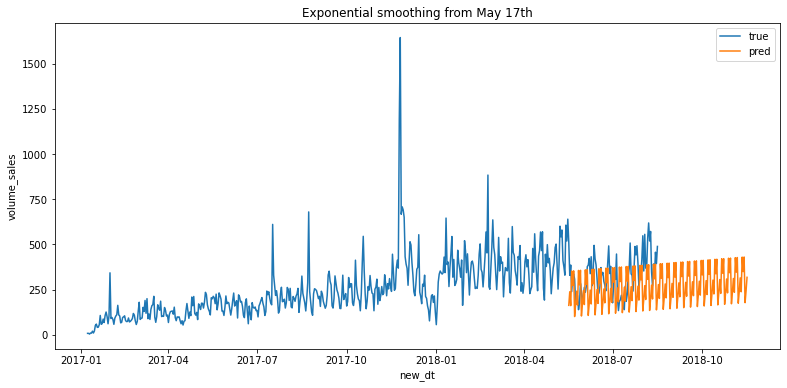

In [1275]:
fig, ax = plt.subplots(figsize=(13,6))
sales = price_pmt['volume_sales']
sns.lineplot(x=sales.index, y=sales, label='true')
sns.lineplot(x=su_pred_time, y=su_pred, label='pred')
#ax.axvline(x=pred_time[0], color='green')

ax.set_title('Exponential smoothing from May 17th')
plt.show()

In [1276]:
#get rmse
test_vals = price_pmt[price_pmt.new_dt > datetime.datetime(2018, 5, 17)]

idx = test_time
s1 = test_vals['volume_sales']
s1.index = pd.DatetimeIndex(test_vals.new_dt)
s1 = s1.reindex(idx, fill_value=0)

rmse = sum([(np.squeeze(pred)[i]-s1[i])**2 for i in range(len(np.squeeze(pred)))])
rmse = np.sqrt(rmse)*1/90
rmse

17.728900874231535

## Deprecated Analysis

In [687]:
price_pmt_f[price_pmt_f['total_items_in_order']>1].sort_values(['order_id','product_id','order_item_id']).head(10)

,product_id,order_id,order_item_id,product_category_name,price,total_items_in_order,order_purchase_timestamp
60772,368c6c730842d78016ad823897a372db,0008288aa423d2a3f00fcb17cd7d8719,1.0,ferramentas_jardim,49.90,2,2018-02-13 22:10:21
60773,368c6c730842d78016ad823897a372db,0008288aa423d2a3f00fcb17cd7d8719,2.0,ferramentas_jardim,49.90,2,2018-02-13 22:10:21
40861,e95ee6822b66ac6058e2e4aff656071a,00143d0f86d6fbd9f9b38ab440ac16f5,1.0,esporte_lazer,21.33,3,2017-10-16 15:29:43
40862,e95ee6822b66ac6058e2e4aff656071a,00143d0f86d6fbd9f9b38ab440ac16f5,2.0,esporte_lazer,21.33,3,2017-10-16 15:29:43
40863,e95ee6822b66ac6058e2e4aff656071a,00143d0f86d6fbd9f9b38ab440ac16f5,3.0,esporte_lazer,21.33,3,2017-10-16 15:29:43
30375,0b0172eb0fd18479d29c3bc122c058c2,001ab0a7578dd66cd4b0a71f5b6e1e41,1.0,eletronicos,24.89,3,2017-12-27 00:38:47
30376,0b0172eb0fd18479d29c3bc122c058c2,001ab0a7578dd66cd4b0a71f5b6e1e41,2.0,eletronicos,24.89,3,2017-12-27 00:38:47
30377,0b0172eb0fd18479d29c3bc122c058c2,001ab0a7578dd66cd4b0a71f5b6e1e41,3.0,eletronicos,24.89,3,2017-12-27 00:38:47
47549,e67307ff0f15ade43fcb6e670be7a74c,001d8f0e34a38c37f7dba2a37d4eba8b,1.0,beleza_saude,18.99,2,2017-05-14 17:19:44
47550,e67307ff0f15ade43fcb6e670be7a74c,001d8f0e34a38c37f7dba2a37d4eba8b,2.0,beleza_saude,18.99,2,2017-05-14 17:19:44


In [688]:
o_dat[o_dat['order_id']=='0016dfedd97fc2950e388d2971d718c7']

,order_id,order_status,order_purchase_timestamp,order_approved_at
75112,0016dfedd97fc2950e388d2971d718c7,delivered,2017-04-28 19:54:40,2017-04-29 10:05:12


In [143]:
payments[payments['order_id']=='0016dfedd97fc2950e388d2971d718c7']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63


In [146]:
items[items['order_id']=='0016dfedd97fc2950e388d2971d718c7']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
38,0016dfedd97fc2950e388d2971d718c7,1,4089861a1bd4685da70bddd6b4f974f1,a35124e2d763d7ca3fbe3b97d143200f,2017-05-05 10:05:12,49.75,20.8


In [139]:
oipp[oipp['order_id']=='0016dfedd97fc2950e388d2971d718c7']

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,payment_value,payment_installments,total_payment,total_items_in_order,product_order_payment,total_product_cost
89300,0016dfedd97fc2950e388d2971d718c7,delivered,2017-04-28 19:54:40,2017-04-29 10:05:12,1.0,4089861a1bd4685da70bddd6b4f974f1,a35124e2d763d7ca3fbe3b97d143200f,2017-05-05 10:05:12,49.75,20.8,ferramentas_jardim,17.92,1.0,838280.75,2,70.55,99.5
89301,0016dfedd97fc2950e388d2971d718c7,delivered,2017-04-28 19:54:40,2017-04-29 10:05:12,1.0,4089861a1bd4685da70bddd6b4f974f1,a35124e2d763d7ca3fbe3b97d143200f,2017-05-05 10:05:12,49.75,20.8,ferramentas_jardim,52.63,5.0,838280.75,2,70.55,99.5
